# Imports

In [1]:
import torch
import pandas as pd
import numpy as np
import re
import os
from glob import glob
from tqdm import tqdm
from transformers import LongformerTokenizer, LongformerModel
import torch
import torch.nn as nn
import torch.nn.functional as F
import datasets

/home/ajeet/Sourav/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data preprocessing

In [2]:
import preprocessing

[nltk_data] Downloading package punkt to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/ajeet/Sourav/pre_trained_weigths...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [37]:
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096",
                                        cache_dir="/home/ajeet/Sourav/pre_trained_weigths")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096",
                                        cache_dir="/home/ajeet/Sourav/pre_trained_weigths")

ConnectionError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /allenai/longformer-base-4096/resolve/main/model.safetensors (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7f5174dd6f90>: Failed to resolve 'huggingface.co' ([Errno -3] Temporary failure in name resolution)"))

In [12]:
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm

Device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Device = 'cpu'

def process_file(item, save_dir, model, tokenizer):
    text, id = item
    # try:
    preprocessing.parse_xml_longformer_patchtst(text, id, save_dir, model, tokenizer, 'cuda')
    # except:
    #     print('failed\n')
    #     return "dummy", {}
    
# Function to process files in parallel
def process_files(file_paths, save_dir, id, desc):
    items = list(zip(file_paths, id))
    dataset_dict = {}
    with Pool(8) as pool:
        partial_process_file = partial(process_file, save_dir=save_dir, model=model, tokenizer=tokenizer)
        results = list(tqdm(pool.imap(partial_process_file, items), total=len(file_paths), desc=desc))

In [2]:
df = pd.read_csv('/home/ajeet/Sourav/train_data.csv')
df.head()

Unnamed: 0     subject_ID  \
0           0  subject1074_1   
1           1  subject1101_1   
2           2  subject1120_1   
3           3  subject1137_1   
4           4  subject1143_1   

                                                text  Anorexia  
0   [pc] [h] 4 keys maybe 5? [w] endo  so why doe...         0  
1    Because he saw a movie once?  It's Canadian ...         0  
2   What book should I read next that will scare ...         0  
3    ''I only drink soda at parties''  Are you ex...         0  
4    Once I named myself 'pros solo', the number ...         0

In [14]:
df = pd.read_csv('/home/ajeet/Sourav/train_data.csv')
ids = df['subject_ID'].tolist()
file_paths = df['text'].tolist()
items = zip(file_paths, ids)
for i in tqdm(items):
    process_file(i, '/home/ajeet/Sourav/dataset', model, tokenizer)
    

0it [00:00, ?it/s]Input ids are automatically padded to be a multiple of `config.attention_window`: 512
173it [00:41,  3.34it/s]

id = subject2167_10 failed to get logits


2332it [27:10,  1.43it/s]


# Dataset

In [3]:
import torch
dataset_dict = torch.load("/home/ajeet/Sourav/lngfrm_patchtst_dataset.pth")

In [4]:
for keys in dataset_dict.keys():
    dataset_dict[keys]['logits_path'] = '/home/ajeet/Sourav/dataset/' + dataset_dict[keys]['logits_path'].split('/')[-1]

In [23]:
for keys in dataset_dict.keys():
    print(dataset_dict[keys])
    break

{'time': [[18, 1], [18, 0], [17, 50], [17, 49], [17, 36], [17, 26]], 'logits_path': '/home/ajeet/Sourav/dataset/subject1113_1.npy', 'label': 1}


In [5]:
import random

def split_dictionary(data):
    # Separate entries with label 0 and label 1
    label_0_entries = {k: v for k, v in data.items() if v['label'] == 0}
    label_1_entries = {k: v for k, v in data.items() if v['label'] == 1}
    
    # Calculate the number of entries to be moved
    num_label_0_to_move = int(0.2 * len(label_0_entries))
    num_label_1_to_move = int(0.4 * len(label_1_entries))
    
    # Randomly select entries to be moved
    label_0_keys_to_move = random.sample(list(label_0_entries.keys()), num_label_0_to_move)
    label_1_keys_to_move = random.sample(list(label_1_entries.keys()), num_label_1_to_move)
    
    # Create the new dictionaries
    moved_entries = {k: label_0_entries[k] for k in label_0_keys_to_move}
    moved_entries.update({k: label_1_entries[k] for k in label_1_keys_to_move})
    
    remaining_entries = {k: v for k, v in data.items() if k not in moved_entries}
    
    return moved_entries, remaining_entries



val_dataset_dict, train_dataset_dict = split_dictionary(dataset_dict)
print("Moved Entries:")
print(len(val_dataset_dict))
print("Remaining Entries:")
print(len(train_dataset_dict))


Moved Entries:
520
Remaining Entries:
1811


In [25]:
for keys in train_dataset_dict.keys():
    print(train_dataset_dict[keys])

{'time': [[6, 25], [6, 23], [6, 19], [19, 50]], 'logits_path': '/home/ajeet/Sourav/dataset/subject1913_1.npy', 'label': 1}
{'time': [[18, 17], [16, 36], [8, 29], [5, 19], [14, 18], [6, 34]], 'logits_path': '/home/ajeet/Sourav/dataset/subject3094_1.npy', 'label': 1}
{'time': [[23, 29]], 'logits_path': '/home/ajeet/Sourav/dataset/subject3883_1.npy', 'label': 1}
{'time': [[8, 49], [7, 40], [6, 5], [6, 4], [19, 40], [5, 24], [0, 25], [0, 17], [1, 44], [21, 37], [2, 53], [19, 28], [21, 37], [4, 19], [4, 16], [3, 55], [3, 53], [2, 41], [3, 58], [1, 11], [1, 32], [1, 24], [23, 24], [3, 38], [5, 29], [4, 38], [3, 56], [3, 39], [3, 51], [3, 34], [6, 18], [5, 58], [5, 43], [1, 54], [1, 43], [4, 53], [22, 35], [22, 33], [22, 28], [15, 52], [4, 44]], 'logits_path': '/home/ajeet/Sourav/dataset/subject5127_1.npy', 'label': 1}
{'time': [[22, 48], [19, 10], [18, 4], [17, 40], [16, 53], [16, 40], [6, 14], [6, 7], [6, 3], [5, 55], [5, 53], [4, 23], [3, 22], [3, 19], [19, 6], [18, 31], [18, 28], [17, 26]

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class TimeSeriesDataset(Dataset):
    def __init__(self, data, max_len):
        self.data = data
        self.max_len = max_len
        self.subjects = list(data.keys())

    def __len__(self):
        return len(self.subjects)

    def __getitem__(self, idx):
        subject = self.subjects[idx]
        time = self.data[subject]['time']
        logits_path = self.data[subject]['logits_path']
        label = self.data[subject]['label']

        # Padding
        padded_time = np.pad(time, ((0, self.max_len - len(time)), (0, 0)), 'constant')

        # print(padded_time.shape, padded_sentiment_score.shape)

        # Create past_observed_mask
        past_observed_mask = np.ones(self.max_len)
        past_observed_mask[len(time):] = 0  # Set mask to 0 for padded values


        return {
            'past_values': torch.tensor(padded_time, dtype=torch.float32),
            'true_label': torch.tensor([label], dtype=torch.float32),
            'past_observed_mask': torch.tensor(np.stack((past_observed_mask, past_observed_mask), axis=1), dtype=torch.bool),
            'text_logits_path': logits_path
        }


In [7]:
from sklearn.model_selection import train_test_split

# Set the maximum length of sequences to 2000
max_len = 2000

# Create dataset
train_dataset = TimeSeriesDataset(train_dataset_dict, max_len)
test_dataset = TimeSeriesDataset(val_dataset_dict, max_len)

# train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [28]:
for data in train_loader:
    print(data['past_values'].shape)
    print(data['past_observed_mask'].shape)
    print(data['true_label'])
    print(data['text_logits_path'])
    break

torch.Size([1, 2000, 2])
torch.Size([1, 2000, 2])
tensor([[0.]])
['/home/ajeet/Sourav/dataset/subject1604_9.npy']


# Model Architecture

### Classifier for Text Data

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 12)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.relu(self.fc3(x))
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

### Classifier for Time series data

In [9]:
from transformers import PatchTSTConfig, PatchTSTForClassification

# classification task with two input channel2 and 3 classes
config = PatchTSTConfig(
    num_input_channels=2,
    num_targets=1,
    context_length=2000,
    patch_length=12,
    stride=12,
    use_cls_token=True,
    # loss='bce',
    head_dropout=0.5,
)
model = PatchTSTForClassification(config=config)

In [10]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Device = 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()
model_patchtst.to(Device)
model_classifier.to(Device)
optimizer1 = torch.optim.Adam(model_classifier.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model_patchtst.parameters(), lr=1e-5)
criterion = torch.nn.BCELoss()
# lambda1 = lambda epoch: 0.94 ** epoch
# scheduler1 = torch.optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[5, 10, 15, 30], gamma=0.1)
# scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer2, milestones=[5, 10, 15, 30], gamma=0.1)
sigmoid = nn.Sigmoid()
alpha, beta = 0.9, 0.4
num_epochs = 10

# Training and Validation

In [11]:
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import os

model_classifier.load_state_dict(torch.load('/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_classifier_2.pt', map_location=Device))
model_patchtst.load_state_dict(torch.load('/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_patchtst_2.pt', map_location=Device))

best_val_loss = 0.4
model.train()
for epoch in range(num_epochs):
    loss_train = 0
    for data in tqdm(train_loader, desc=f"training epoch = {epoch}"):
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        labels = data['true_label'].to(Device)
        output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
        # print(output1.prediction_logits)
        output1 = sigmoid(output1.prediction_logits)
        output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
        # print(output2.shape)
        output2 = model_classifier(output2)
        # print(output1, output2, labels)
        output2 = alpha*output2 + beta*output1
        loss = criterion(output2, labels)
        loss.backward()
        loss_train += loss.item()
        optimizer1.step()
        optimizer2.step()
    # scheduler2.step()
    # scheduler1.step()
    print(f"training_loss = {loss_train/len(train_loader)}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in tqdm(test_loader, desc=f"validation epoch = {epoch}"):
            labels = data['true_label'].to(Device)
            output1 = model_patchtst(past_values=data['past_values'].to(Device), past_observed_mask=data['past_observed_mask'].to(Device))
            output1 = sigmoid(output1.prediction_logits)
            output2 = torch.from_numpy(np.load(data['text_logits_path'][0])).to(Device)
            # print(output2.shape)
            output2 = model_classifier(output2)
            output2 = alpha*output2 + beta*output1
            loss = criterion(output2, labels)
            val_loss += loss.item()
    val_loss /= len(test_loader)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_patchtst.state_dict(),
               os.path.join("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt",
                            f"model_best_patchtst_2.pt"))
        torch.save(model_classifier.state_dict(),
               os.path.join("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt",
                            f"model_best_classifier_2.pt"))

    if (epoch+1)%5 == 0:
        torch.save(model_classifier.state_dict(),
               os.path.join("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt",
                            f"classifier_2_epoch_{epoch+1}_val_loss_{val_loss}.pt"))
        torch.save(model_patchtst.state_dict(),
               os.path.join("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt",
                            f"patchtst_2_epoch_{epoch+1}_val_loss_{val_loss}.pt"))

    # print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

training epoch = 0:   0%|          | 0/1811 [00:00<?, ?it/s]

training epoch = 0: 100%|██████████| 1811/1811 [15:22<00:00,  1.96it/s]


training_loss = 0.15793422819154193


validation epoch = 0: 100%|██████████| 520/520 [05:07<00:00,  1.69it/s]


Val loss: 0.2677


training epoch = 1: 100%|██████████| 1811/1811 [13:49<00:00,  2.18it/s] 


training_loss = 0.16023916915750494


validation epoch = 1: 100%|██████████| 520/520 [02:02<00:00,  4.25it/s]


Val loss: 0.2902


training epoch = 2: 100%|██████████| 1811/1811 [11:41<00:00,  2.58it/s]


training_loss = 0.15769007554695524


validation epoch = 2: 100%|██████████| 520/520 [01:52<00:00,  4.63it/s]


Val loss: 0.2739


training epoch = 3: 100%|██████████| 1811/1811 [07:19<00:00,  4.12it/s]


training_loss = 0.15783626693874542


validation epoch = 3: 100%|██████████| 520/520 [01:40<00:00,  5.18it/s]


Val loss: 0.3072


training epoch = 4: 100%|██████████| 1811/1811 [06:53<00:00,  4.38it/s]


training_loss = 0.1565314409403482


validation epoch = 4: 100%|██████████| 520/520 [01:36<00:00,  5.41it/s]


Val loss: 0.2816


training epoch = 5: 100%|██████████| 1811/1811 [06:14<00:00,  4.83it/s]


training_loss = 0.15465258799893727


validation epoch = 5:  82%|████████▏ | 424/520 [01:12<00:16,  5.86it/s]


KeyboardInterrupt: 

# Testing

In [12]:
testing_dataset = pd.read_csv("/home/ajeet/Sourav/test_data.csv")
time_dataset_dict = torch.load("/home/ajeet/Sourav/time_dataset_test.pth")

In [13]:
testing_dataset

Unnamed: 0 subject_ID  num_writings  \
0              0     1152_1             4   
1              1     1169_1            14   
2              2     1441_1            55   
3              3     1518_1            31   
4              4     1773_1             1   
...          ...        ...           ...   
3195        3195     9950_9           198   
3196        3196     9961_9            36   
3197        3197     9978_9             7   
3198        3198     9981_9             1   
3199        3199     9982_9             5   

                                                   text  Anorexia  
0      Student at uw. Need a few hours away from cam...         1  
1         Haha, nailed it dude.\n     Rings are defi...         1  
2         Right, which is why I said those people wo...         1  
3         I just have a lot of self hatred and depri...         1  
4         Thank you for your long reply! I have been...         1  
...                                                 ...       ...  
3195      The simplest thing to do would be to have ...         0  
3196      I think i am over him now, it's just that ...         0  
3197      While it's hard to tell with all of the ch...         0  
3198          Have you heard of the band Pickle Snack?          0  
3199      An upcomming deadline  I used to think I w...         0  

[3200 rows x 5 columns]

In [14]:
d = {}
with open("/home/ajeet/Sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [15]:
x=0
for k in time_dataset_dict.keys():
    x = max(np.array(time_dataset_dict[k]).shape[0], x)
print(x)

207


In [15]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, time_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.time_dict = time_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*.npy"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        time_list = []
        mask_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                time = self.time_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(len(time))
                time = np.pad(time, ((0, 2000 - len(time)), (0, 0)), 'constant')
                time = torch.tensor(time, dtype = torch.float32)
                mask = np.ones(2000)
                mask[len(time):] = 0
                mask = torch.tensor(np.stack((mask, mask), axis=1), dtype=torch.bool)
                time_list.append(time.unsqueeze(0))
                mask_list.append(mask.unsqueeze(0))

            except:  
                time_list.append(0)
                mask_list.append(0)  
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, time_list, mask_list, delay_list, label

In [16]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset_longformer_without_aug', d, time_dataset_dict)

In [196]:
for i, j, k, l, m in test_dataset:
    print(i)
    print(j)
    print(k)
    print(m)
    print(l)
    break

['/home/ajeet/Sourav/test_dataset_longformer_without_aug/1/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/2/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/3/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/4/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/5/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/6/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/7/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/8/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/9/5825.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/10/5825.npy']
[tensor([[[ 9., 44.],
         [ 4.,  5.],
         [ 4.,  0.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]]), tensor([[[16., 46.],
         [ 6., 15.],
         [ 2., 52.],
         ...,
         [ 0.,  0.],
         [ 0.,  0.],
         [ 0.,  0.]]]), tensor([[[20., 28.],


In [17]:
import torch.nn as nn
sigmoid = nn.Sigmoid()

def evaluate(test_dataset, model_c, model_p):
    probs, target, delays = [], [], []
    model_c.to(Device)
    model_p.to(Device)
    model_c.eval()
    model_p.eval()
    alpha, beta = 0.9, 0.3
    with torch.no_grad():
        for features_text, features_time, features_mask, delay, label in tqdm(test_dataset):
            temp = []
            for logits, temporal_data, mask in zip(features_text, features_time, features_mask):
                try:
                    output1 = model_p(past_values=temporal_data.to(Device), past_observed_mask=mask.to(Device))
                    output1 = sigmoid(output1.prediction_logits)
                    output2 = torch.from_numpy(np.load(logits)).to(Device)
                    output2 = model_c(output2)
                    output2 = alpha*output2 + beta*output1

                    temp.append(output2[0][0].cpu().numpy())
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            delays.append(delay)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target, delays

In [18]:
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_patchtst = PatchTSTForClassification(config=config)
model_classifier = BinaryClassifier()

In [29]:
from tqdm import tqdm

# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
# model_classifier.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/classifier_epoch_50_val_loss_0.26276400766766184.pt"))
model_classifier.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_classifier_1.pt"))
# model_patchtst.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/patchtst_epoch_50_val_loss_0.26276400766766184.pt"))
model_patchtst.load_state_dict(torch.load("/home/ajeet/Sourav/lngfmr_attn_ptsts_ckpt/model_best_patchtst_1.pt"))
model_classifier.to(Device)
model_patchtst.to(Device)

PatchTSTForClassification(
  (model): PatchTSTModel(
    (scaler): PatchTSTScaler(
      (scaler): PatchTSTStdScaler()
    )
    (patchifier): PatchTSTPatchify()
    (masking): Identity()
    (encoder): PatchTSTEncoder(
      (embedder): PatchTSTEmbedding(
        (input_embedding): Linear(in_features=12, out_features=128, bias=True)
      )
      (positional_encoder): PatchTSTPositionalEncoding(
        (positional_dropout): Identity()
      )
      (layers): ModuleList(
        (0-2): 3 x PatchTSTEncoderLayer(
          (self_attn): PatchTSTAttention(
            (k_proj): Linear(in_features=128, out_features=128, bias=True)
            (v_proj): Linear(in_features=128, out_features=128, bias=True)
            (q_proj): Linear(in_features=128, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
          (dropout_path1): Identity()
          (norm_sublayer1): PatchTSTBatchNorm(
            (batchnorm): BatchNorm1d(128,

In [30]:
probs, label, delay = evaluate(test_dataset, model_classifier, model_patchtst)

100%|██████████| 320/320 [00:37<00:00,  8.53it/s]


In [21]:
probs

array([[0.02305367, 0.04384596, 0.02026879, ..., 0.01591573, 0.01971038,
        0.06186297],
       [0.01586967, 0.01631222, 0.01790366, ..., 0.01492098, 0.02236704,
        0.01745587],
       [0.01464211, 0.01601442, 0.01339533, ..., 0.02147141, 0.0271822 ,
        0.02145563],
       ...,
       [0.03152484, 0.03027351, 0.05740803, ..., 0.01804163, 0.03974009,
        0.02796828],
       [0.01427091, 0.01316032, 0.01419177, ..., 0.0145559 , 0.01374636,
        0.01440399],
       [0.02229751, 0.21199879, 0.05939277, ..., 0.06080154, 0.54173398,
        0.01395141]])

In [22]:
import math

def get_delays(preds, delays_all):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                # delay += delays_all[i][j]
                break
            delay += delays_all[i][j]
        delays.append(delay)
    return delays

import numpy as np

def lco(k, o):
    if k - o > 700:
        return 1.0
    elif k - o < -700:
        return 0.0
    else:
        return 1 - (1 / (1 + np.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

      threshold  f1_score
0         0.000  0.227147
1         0.001  0.227147
2         0.002  0.227147
3         0.003  0.227147
4         0.004  0.227147
...         ...       ...
1005      1.005  0.746269
1006      1.006  0.746269
1007      1.007  0.746269
1008      1.008  0.746269
1009      1.009  0.746269

[1010 rows x 2 columns]


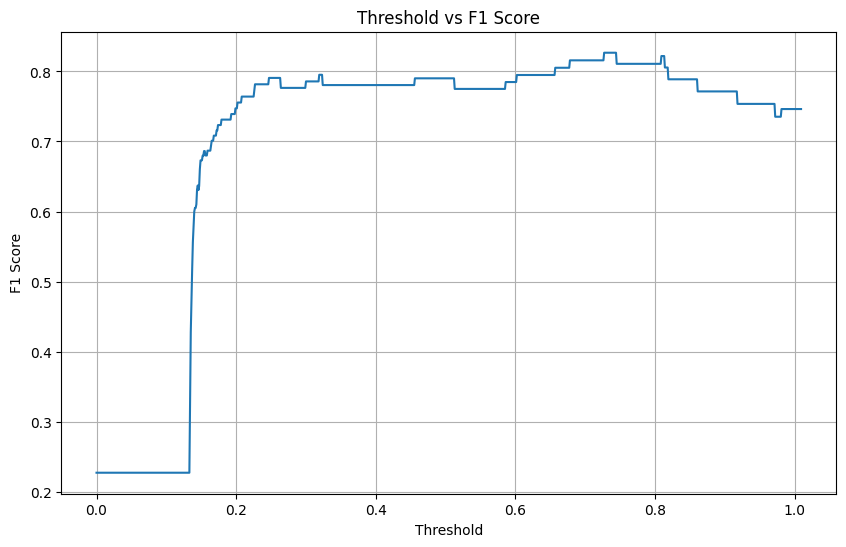

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 7: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [33]:
results_df['f1_score'][735]

0.8266666666666667

      threshold  f1_score  precision    recall      erde5     erde50
0         0.000  0.227147   0.128125  1.000000  11.256651  11.170898
1         0.001  0.227147   0.128125  1.000000  11.256651  11.170898
2         0.002  0.227147   0.128125  1.000000  11.256651  11.170898
3         0.003  0.227147   0.128125  1.000000  11.256651  11.170898
4         0.004  0.227147   0.128125  1.000000  11.256651  11.170898
...         ...       ...        ...       ...        ...        ...
1005      1.005  0.746269   0.961538  0.609756   5.595485   4.229492
1006      1.006  0.746269   0.961538  0.609756   5.555446   4.189453
1007      1.007  0.746269   0.961538  0.609756   5.555446   4.189453
1008      1.008  0.746269   0.961538  0.609756   5.555446   4.189453
1009      1.009  0.746269   0.961538  0.609756   5.555446   4.189453

[1010 rows x 6 columns]


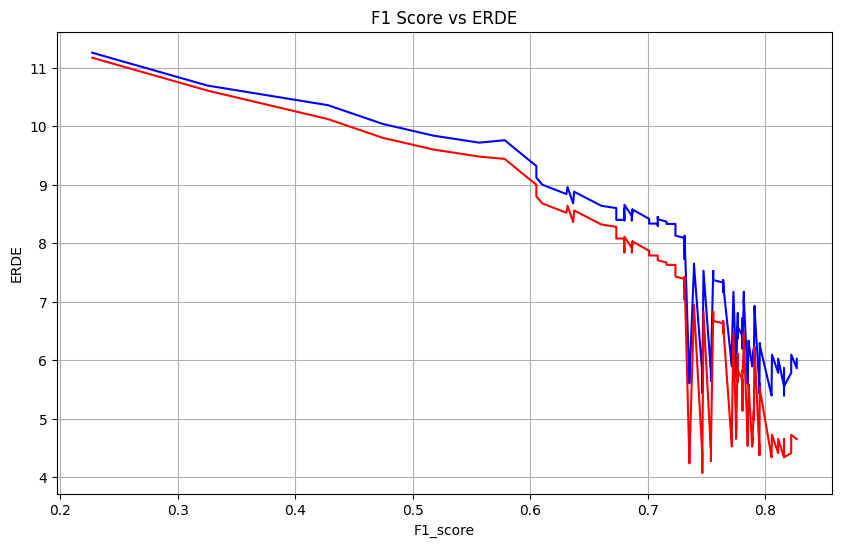

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores, precision, recall, ERDE5, ERDE50 = [], [], [], [], []
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    delays = get_delays(pred_labels, delay)

    preds = []
    for i in pred_labels:
        if sum(i) > 7: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1_scores.append(f1_score(label, preds))
    precision.append(precision_score(label, preds))
    recall.append(recall_score(label, preds))

    preds = []
    for i in pred_labels:
        if sum(i) > 0: 
            preds.append(1)
        else: 
            preds.append(0)

    ERDE5.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o))
    ERDE50.append(100*calculate_ERDE(preds, delays, label, cfn, ctp, o*10))



# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores,
    'precision': precision,
    'recall': recall,
    'erde5': ERDE5,
    'erde50': ERDE50
})

# Print the DataFrame
print(results_df)

# Plot the curve
f1_scores = np.array(f1_scores)
ERDE5 = np.array(ERDE5)
ERDE50 = np.array(ERDE50)
sorted_indices = np.argsort(f1_scores)
sorted_erde5 = ERDE5[sorted_indices]
sorted_erde50 = ERDE50[sorted_indices]
sorted_f1 = f1_scores[sorted_indices]

plt.figure(figsize=(10, 6))

plt.plot(sorted_f1, sorted_erde5, color='blue')
plt.plot(sorted_f1, sorted_erde50, color='red')
plt.title('F1 Score vs ERDE')
plt.xlabel('F1_score')
plt.ylabel('ERDE')
plt.grid(True)
plt.show()


In [33]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/longformer_patchtst_2.csv')

In [352]:
probs

array([[0.13996539, 0.1398979 , 0.13982563, ..., 0.1397368 , 0.13973571,
        0.13974059],
       [0.13974172, 0.18416891, 0.1397346 , ..., 0.33630618, 0.14568909,
        0.13973917],
       [0.80021334, 0.17437041, 0.14002544, ..., 0.54052407, 0.83972037,
        0.83715647],
       ...,
       [0.42641455, 0.1398475 , 0.14085872, ..., 0.1397732 , 0.14011969,
        0.14010799],
       [0.82842261, 0.13973068, 0.83274132, ..., 0.83967632, 0.19111463,
        0.13973582],
       [0.20826629, 0.69597352, 0.82306713, ..., 0.15014043, 0.73197436,
        0.67510533]])

In [353]:
pred_labels = []
for i in range(0,len(probs)):
    temp = []
    for j in range(0, len(probs[i])):
        if probs[i][j]>=0.839: temp.append(1)
        else: temp.append(0)
    pred_labels.append(temp)

In [354]:
for i, j in zip(pred_labels, label):
    print(i, j)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0] 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 1
[1, 1, 1, 1, 0, 0, 1, 0, 0, 1] 0
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0] 0
[0, 1, 0, 0, 0, 0, 1, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 1, 1, 0, 0, 0, 0, 0, 0] 0
[0, 0, 1, 1, 1, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
[1, 0, 1, 0, 0, 1, 1, 0, 0, 0] 0
[0, 0, 0, 0, 1, 1, 1, 0, 0, 0] 0
[0, 1, 1, 1, 1, 0, 1, 1, 0, 0] 0
[0, 0, 1, 1, 1, 1, 0, 0, 0, 0] 0
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 0
[0, 0, 0, 

In [356]:
delays = get_delays(pred_labels, delay)
print(delays)

[165, 110, 160, 1379, 1214, 42, 1179, 1245, 573, 1279, 1276, 548, 165, 308, 0, 0, 5, 38, 503, 64, 34, 1030, 1998, 0, 659, 0, 28, 2, 4, 72, 1210, 215, 55, 1173, 0, 16, 1746, 0, 1192, 0, 0, 0, 24, 663, 228, 0, 0, 0, 1145, 0, 12, 1742, 4, 0, 400, 844, 5, 515, 1148, 0, 30, 491, 42, 0, 538, 141, 1985, 0, 171, 1, 1130, 965, 1800, 0, 102, 15, 1215, 0, 36, 99, 420, 1688, 612, 10, 0, 1, 1159, 1037, 9, 12, 1409, 14, 0, 455, 0, 12, 1514, 0, 78, 1999, 5, 50, 315, 22, 77, 4, 1036, 126, 1093, 0, 7, 0, 0, 23, 646, 331, 225, 549, 46, 110, 221, 7, 164, 57, 608, 1332, 1151, 0, 454, 335, 1006, 0, 88, 1182, 10, 0, 0, 1025, 0, 16, 0, 0, 0, 1241, 245, 0, 1108, 0, 328, 0, 935, 88, 956, 1589, 3, 106, 228, 30, 6, 1, 1766, 0, 144, 0, 12, 0, 0, 8, 1, 779, 674, 0, 0, 999, 1092, 285, 504, 144, 0, 695, 1121, 1957, 40, 0, 27, 581, 1234, 340, 4, 10, 252, 128, 1207, 95, 790, 304, 4, 0, 4, 468, 5, 436, 0, 958, 74, 42, 44, 10, 68, 1497, 0, 0, 317, 1034, 1108, 1167, 0, 8, 991, 21, 34, 39, 32, 944, 6, 223, 147, 0, 75, 199

In [357]:
from sklearn.metrics import precision_score, recall_score

preds = []
for i in pred_labels:
    if sum(i)>7: preds.append(1)
    else: preds.append(0)

precision = precision_score(label, preds)
recall = recall_score(label, preds)
print(f"precision = {precision}\nrecall = {recall}")

precision = 0.8421052631578947
recall = 0.7804878048780488


In [344]:
# for i, j, k in zip(preds, label, delays):
#     if i==j==1:
#         print(i, j, k)

In [345]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 6.802616672104554%
ERDE50 = 6.022460937504354%
